# Проект, Часть 2
## Царькова Анастасия, Скоробогатов Денис, Анвардинов Шариф

Задача:
  1. подготовить корпус к выделению тем: нормализовать, лемматизировать, отфильтровать слова по частоте;
  2. обучить PLSA- или LDA-модель, проинтерпретировать результаты;
  3. построить векторное представление слов корпуса;
  4. кластеризовать слова, визуализировать кластера;
  5. сделать выводы о содержимом статей, относящихся к брэнду.

Необходимые для выполнения кода библиотеки: nltk, gensim, scikit-learn, pyldavis.

### 1. Корпус и предобработка

Взят из части 1 и расширен тем же кодом в 4 раза добавлением еще 3 недель новостей. Дальше будем работать со статьями, где упоминается Google:

In [1]:
import re
import json

with open('hn-corpus-stripped.txt') as fd:
    data = json.load(fd)
    print('Total texts:', len(data),
          'from', min(d['time'] for d in data.values()),
          'to', max(d['time'] for d in data.values()))

    data = [x['text'] for x in data.values() if re.search(r'\bgoogle\b', x['text'])]
    print('Brand-related texts:', len(data))

Total texts: 25982 from 2017-10-03 22:39:13 to 2017-11-20 13:47:59
Brand-related texts: 4581


In [2]:
data = [''.join(c if c in 'abcdefghijklmnopqrstuvwxyz.,' or c.isspace() else ' ' for c in x) for x in data]

Лемматизируем при помощи WordNet (т.к. тексты на английском) и удалим стоп-слова (апострофы строка выше заменяет на пробелы по причинам, описанным в прошлой части). К стоп-словам также отнесем все слова из 1 буквы.

In [3]:
import nltk
import nltk.stem
import nltk.corpus
import nltk.tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/pyos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pyos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pyos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
%%time
lm = nltk.stem.WordNetLemmatizer()
sw = nltk.corpus.stopwords.words('english')
normed = [[lm.lemmatize(w) for w in nltk.word_tokenize(t.replace(',', ' ').replace('.', ' ')) if len(w) > 1 and w not in sw] for t in data]

CPU times: user 1min 17s, sys: 108 ms, total: 1min 17s
Wall time: 1min 17s


In [76]:
print('Total words:', sum(len(x) for x in normed))

Total words: 4359224


In [77]:
print('Unique words:', len({w for x in normed for w in x}))

Unique words: 93293


In [78]:
import collections

print('Most frequent words:')
for w, c in collections.Counter(w for x in normed for w in x).most_common(20):
    print(c, w)

Most frequent words:
20720 one
18917 like
17694 new
17522 time
16807 google
15988 data
13962 company
13683 people
13456 also
12860 use
12753 get
12634 user
12409 would
12236 make
11179 year
10671 work
10499 way
10085 system
10028 need
9350 first


In [79]:
print('Words occurring in most texts:')
for w, c in collections.Counter(w for x in normed for w in set(x)).most_common(20):
    print(c, w)

Words occurring in most texts:
4581 google
3494 one
3452 new
3414 like
3356 also
3285 time
3100 make
3043 get
2991 use
2784 way
2731 work
2721 first
2693 need
2590 even
2566 year
2547 would
2521 using
2521 many
2498 see
2465 people


93293 уникальных слов это слишком много, чтобы быстро применить LDA, поэтому отсечем наиболее частые 10000.

In [80]:
accepted = {w for w, c in collections.Counter(w for x in normed for w in x).most_common(10000)}
normed = [[w for w in t if w in accepted] for t in normed]

Остальные ~80000 слов составляли примерно 10% корпуса:

In [81]:
print('Total words:', sum(len(x) for x in normed))
print('Unique words:', len({w for x in normed for w in x}))

Total words: 3964788
Unique words: 10000


### 2. Выделение тем с помощью LDA

Воспользуемся реализацией LDA с поддержкой многопоточности из библиотеки gensim.

In [11]:
import pickle
import gensim
import gensim.models
import gensim.corpora

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [82]:
dictionary = gensim.corpora.Dictionary(normed)
corpus = [dictionary.doc2bow(text) for text in normed]

In [14]:
dictionary.save_as_text('dict')
gensim.corpora.MmCorpus.serialize('corpus', corpus)

In [15]:
for topics, passes in [(20, 20), (60, 10), (100, 10)]:
    print('{} topics...'.format(topics))
    lda = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, num_topics=topics,
                                                  chunksize=1000, passes=passes, workers=32)
    with open('lda-{}'.format(topics), 'wb') as fd:
        pickle.dump(lda, fd)

20 topics...
60 topics...
100 topics...


In [13]:
import os
import pyLDAvis
import pyLDAvis.gensim

In [14]:
dictionary = gensim.corpora.Dictionary.load_from_text('dict')
corpus = gensim.corpora.MmCorpus('corpus')
ldas = {}
for file in os.listdir():
    if file.startswith('lda-'):
        with open(file, 'rb') as fd:
            ldas[int(file[4:])] = pickle.load(fd)

In [38]:
for t, ws in ldas[20].print_topics(num_topics=-1, num_words=10):
    print(t, *re.findall('"[^"]+"', ws), sep=' ')

0 "year" "said" "would" "one" "state" "new" "house" "american" "people" "market"
1 "data" "learning" "machine" "ai" "system" "google" "cloud" "technology" "network" "customer"
2 "share" "email" "blog" "new" "game" "november" "crispr" "court" "twitter" "right"
3 "author" "scholar" "pubmed" "nature" "fig" "al" "time" "et" "brain" "google"
4 "user" "code" "language" "api" "new" "go" "javascript" "web" "developer" "feature"
5 "data" "file" "system" "use" "one" "database" "access" "like" "service" "user"
6 "wikipedia" "one" "new" "could" "year" "may" "disease" "retrieved" "say" "animal"
7 "company" "university" "new" "technology" "ai" "year" "said" "human" "world" "one"
8 "woman" "men" "one" "google" "id" "say" "said" "damore" "would" "people"
9 "like" "people" "thing" "one" "get" "time" "think" "really" "make" "way"
10 "com" "security" "user" "service" "data" "account" "email" "information" "internet" "website"
11 "facebook" "company" "news" "medium" "twitter" "ad" "people" "google" "socia

Среди тем просматриваются некоторые осмысленные: например, #4 о языках программирования ("go" в этом контексте это язык от Google), #11 о социальных сетях, #12 о разработке мобильных приложений, #14 о модной нынче технологии blockchain, #16 о самоуправляемых автомобилях (слова "one" и "year" туда попали потому что в целом тема звучит примерно как "Autonomous cars without human drivers are coming to California next year"), или #17 о смартфонах (в том числе на Android). При этом есть и бред: #19, например, похожа на отдельные слова из веб-стандарта &mdash; к Google, возможно, какое-то отношение имеет, но тема далеко не очевидна.

In [39]:
for t, ws in ldas[60].print_topics(num_topics=-1, num_words=10):
    print(t, *re.findall('"[^"]+"', ws), sep=' ')

0 "data" "device" "security" "user" "information" "privacy" "use" "system" "access" "message"
1 "window" "open" "new" "click" "share" "linux" "software" "download" "system" "file"
2 "user" "product" "customer" "page" "search" "content" "use" "data" "feature" "time"
3 "science" "review" "cell" "crispr" "research" "dna" "code" "one" "gene" "data"
4 "bitcoin" "blockchain" "transaction" "network" "block" "one" "time" "system" "new" "would"
5 "one" "year" "would" "people" "say" "time" "new" "life" "like" "even"
6 "function" "number" "value" "var" "log" "one" "return" "object" "event" "console"
7 "price" "u" "market" "tesla" "new" "exchange" "system" "trading" "money" "time"
8 "google" "company" "tech" "said" "one" "year" "new" "people" "voice" "amazon"
9 "nuclear" "said" "power" "would" "china" "new" "featured" "economic" "trump" "ago"
10 "facebook" "ad" "company" "said" "russian" "people" "social" "like" "twitter" "medium"
11 "web" "language" "application" "j" "react" "javascript" "go" "de

Рассматривать модель со 100 темами, кажется, смысла нет.

Визуализация LDAvis состоит из двух частей. Слева отображены все выделенные темы, спроецированные в двумерное пространство с сохранением относительного расстояния между ними. Размер круга показывает насколько сильно тема представлена в корпусе.

При выборе какой-нибудь темы справа отображаются наиболее значимые в ней слова. По умолчанию "значимость" это просто условная вероятность встретить слово в документе на данную тему. Параметр $\lambda$ позволяет добавить влияние частоты слова в корпусе в целом: чем ближе он к нулю, тем более значимыми считаются слова, шанс увидеть которые значительно выше в текстах на выбранную тему, чем в произвольной статье.

In [26]:
pyLDAvis.display(pyLDAvis.gensim.prepare(ldas[20], corpus, dictionary))

/place/home/pyos/virtualenv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Можно заметить, что многие темы довольно сильно пересекаются. Действительно, маловероятно, что в корпусе из статей за месяц содержится много различных текстов про одну компанию. Реальное количество тем скорее всего где-то на уровне 5.

In [25]:
pyLDAvis.display(pyLDAvis.gensim.prepare(ldas[60], corpus, dictionary))

/place/home/pyos/virtualenv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


### 3. word2vec

В качестве входа потребуются уже не тексты, а предложения.

In [30]:
lm = nltk.stem.WordNetLemmatizer()
sw = nltk.corpus.stopwords.words('english')
sentences = [[lm.lemmatize(w) for w in nltk.word_tokenize(s.replace(',', ' ')) if len(w) > 1 and w not in sw]
             for t in data for s in nltk.tokenize.sent_tokenize(t)]

In [36]:
next(s for s in sentences if len(s) >= 10)

['check',
 'request',
 'ibm',
 'threat',
 'database',
 'group',
 'co',
 'founded',
 'city',
 'london',
 'police',
 'promise',
 'snooping',
 'request',
 'richard',
 'chirgwin',
 'posted',
 'security',
 'th',
 'november',
 'gmt',
 'global',
 'cyber',
 'alliance',
 'given',
 'world',
 'new',
 'free',
 'domain',
 'name',
 'service',
 'resolver',
 'advanced',
 'offering',
 'unusually',
 'strong',
 'security',
 'privacy',
 'feature']

In [40]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [41]:
model = gensim.models.word2vec.Word2Vec(sentences, workers=32, size=300, min_count=15, window=10, sample=1e-3)
model.init_sims(replace=True)
model.save("word2vec")

### 4. Кластеризация векторов слов

In [67]:
import pandas as pd
import numpy as np
import sklearn as sl
import sklearn.cluster
import sklearn.manifold
import sklearn.decomposition
import matplotlib.cm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [46]:
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

In [96]:
kmeans = sklearn.cluster.KMeans(n_clusters=30, random_state=0).fit(tokens)

Последуем рекомендации из [документации к sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) и перед его применением уменьшим размерность векторов до 50, оставив только самые значимые главные компоненты.

In [109]:
pca = sklearn.decomposition.PCA(n_components=50)
reduced = pca.fit_transform(tokens)

In [111]:
tsne = sklearn.manifold.TSNE(n_iter=1000, n_components=2, random_state=42)
x, y = tsne.fit_transform(reduced).T

Для каждого кластера нарисуем какое-нибудь близкое к центру слово. Поскольку редкие слова мало что нам скажут (и, скорее всего, являются бредом), будем предпочитать часто встречающиеся. (Стоит заметить, что кластера строились в оригинальном 300-мерном пространстве, поэтому их центры вовсе не обязаны находиться рядом с центрами "пятен" в визуализации.)

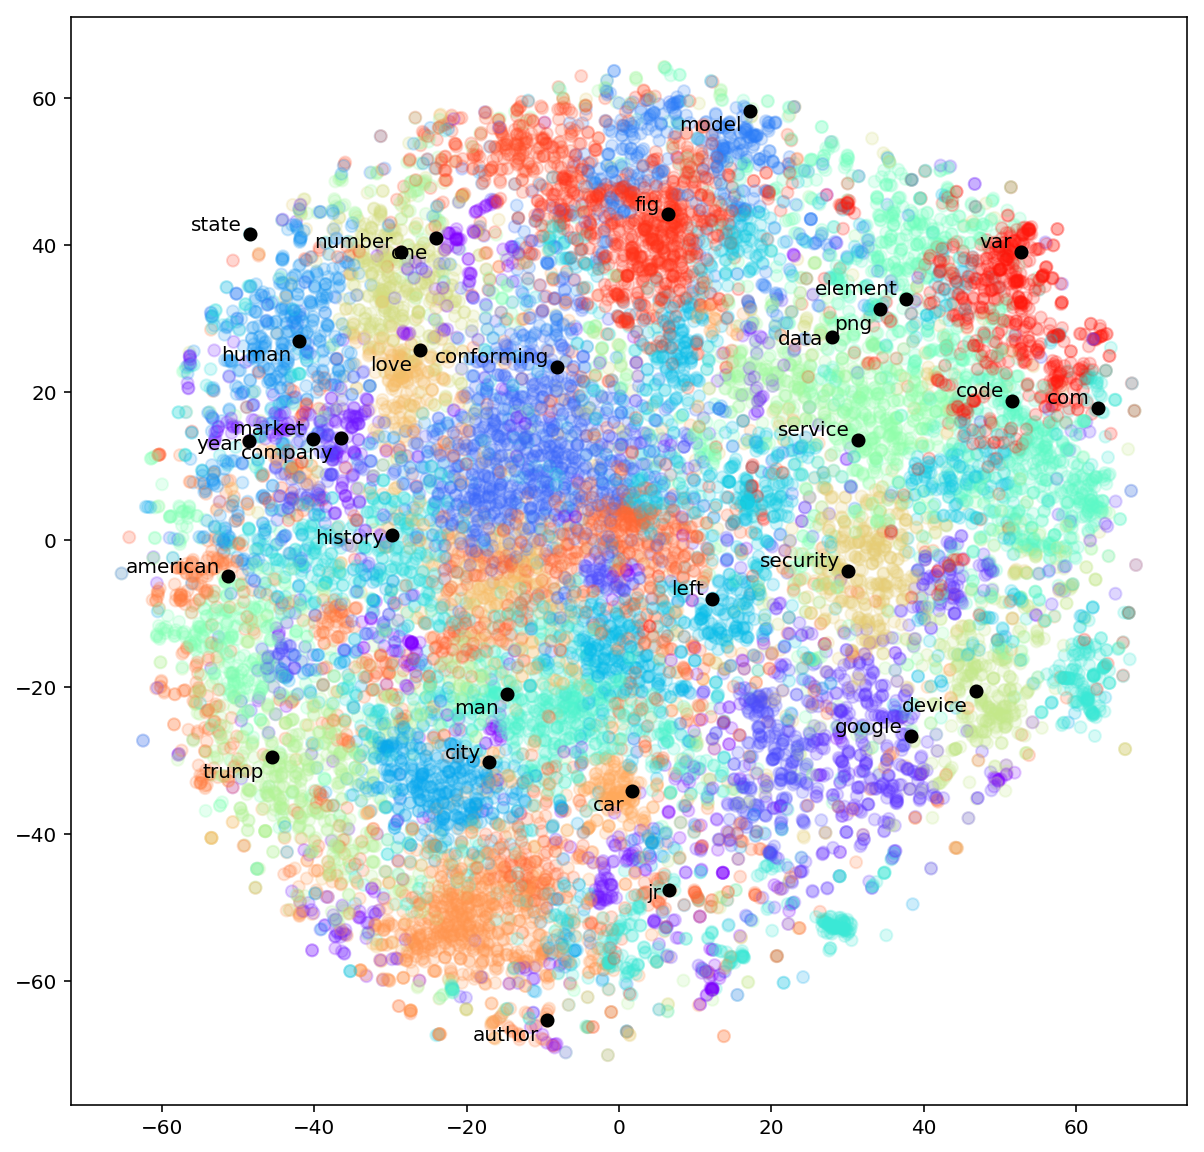

In [113]:
import random

frequencies = collections.Counter(w for t in normed for w in t)
selected = [None] * (kmeans.labels_.max() - kmeans.labels_.min() + 1)
for i, w in enumerate(labels):
    if w in frequencies:
        cluster = kmeans.labels_[i]
        d = tokens[i] - kmeans.cluster_centers_[cluster]
        d = d.dot(d) / frequencies[w]
        if selected[cluster] is None or d < selected[cluster][2]:
            selected[cluster] = i, w, d

colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(selected) + 1))
plt.figure(figsize=(10, 10)) 
plt.scatter(x, y, color=colors[kmeans.labels_], alpha=0.2)
plt.scatter(x[[i for i, w, d in selected]], y[[i for i, w, d in selected]], color='k')            

selected = {w for i, w, d in selected}
for i, w in enumerate(labels):
    if w in selected:
        dy = random.choice((-12, 0, -6))
        plt.annotate(w, xy=(x[i], y[i]), xytext=(-4, dy), textcoords='offset points', ha='right', va='bottom', color='black')
plt.show()

### 5. Вывод